- Remove useless libraries

In [1]:
#######################     LIBRARIES     ##########################
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l2
from hyperopt import STATUS_OK, tpe, Trials, hp, fmin
from hyperopt.pyll.stochastic import sample
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
#from matplotlib.ticker import nearestLocator, FormatStrFormatter
from tensorflow.keras.optimizers import Adam,Nadam,Adamax
from ann_functions2D_new_mod_noloop import rk2, compute_randomized_SVD, sliding_windows, getOpti, reshape_lstm, getModel, kCrossVal, transfBestparam, kCrossValSingle, create_model, train_model, load_model, save_model
from time import perf_counter
import pandas
import pickle
import os
import tensorflow as tf
import keras.backend as K
from keras.regularizers import l2
from hyperopt import STATUS_OK, tpe, Trials, hp, fmin
from hyperopt.pyll.stochastic import sample
from keras.models import Model
from keras.layers import Dense, Input, LSTM, Reshape, Dropout, TimeDistributed
from tensorflow.keras.models import model_from_json
from scipy.integrate import odeint
import scipy.io as sio
from os import chdir, getcwd
import mat73


import scipy.io
from scipy.interpolate import griddata

seed = 7

train = False
scaling = True
save = False
HPO = False
interpolate = True

In [2]:
# ########################     INPUTS     ##########################
path = './data/reaction_diffusion/'

In [3]:
# ########################   DATA     ##########################

#Time
tlf_0 = 0.
thf_0 = 0.
Tlf = 80. 
Thf = 40.

#Load data train
data_lf = mat73.loadmat(path + 'data_train_LF_RD.mat')
data_hf = scipy.io.loadmat(path + 'data_train_HF_RD.mat')

t_lf = data_lf['t']
u_lf = data_lf['U']

t_hf = data_hf['t']
u_hf = data_hf['U']

Nx_lf, Ny_lf, Nt_lf_train, N_mu_train = u_lf.shape
Nx_hf, Ny_hf, Nt_hf_train, N_mu_train = u_hf.shape

#Load data test
data_lf_test = mat73.loadmat(path + 'data_test_LF_RD.mat')
data_hf_test = mat73.loadmat(path + 'data_test_HF_RD.mat')

t_lf_test = data_lf_test['t']
u_lf_test = data_lf_test['U']

t_hf_test = data_hf_test['t']
u_hf_test = data_hf_test['U']

Nx_lf, Ny_lf, Nt_lf_test, N_mu_test = u_lf_test.shape
Nx_hf, Ny_hf, Nt_hf_test, N_mu_test = u_hf_test.shape

#Same time frequency for LF and HF in this example
Nt_train = Nt_lf_train = Nt_hf_train
Nt_test  = Nt_lf_test  = Nt_hf_test

#Parameters
mu_0 = 0.5
mu_1 = 1.5

mu_train = np.linspace(mu_0, mu_1, N_mu_train, endpoint = True)
mu_test = np.linspace(mu_0, mu_1, N_mu_test, endpoint = True)

In [4]:
#########################   INTERPOLATION     ##########################
x_LF = data_lf['x']
x_HF = data_hf['x']

coord_x_LF, coord_y_LF = np.meshgrid(x_LF, x_LF)
coord_LF = np.stack((coord_x_LF, coord_y_LF), axis = 2).reshape(-1,2)

coord_x_HF, coord_y_HF = np.meshgrid(x_HF, x_HF)
coord_HF = np.stack((coord_x_HF, coord_y_HF), axis = 2).reshape(-1,2)

if interpolate:
    u_lf = griddata(coord_LF, u_lf.reshape(-1, Nt_train, N_mu_train), coord_HF, method='nearest').reshape(Nx_hf, Ny_hf, Nt_train, N_mu_train)
    u_lf_test = griddata(coord_LF, u_lf_test.reshape(-1, Nt_lf_test, N_mu_test), coord_HF, method='nearest').reshape(Nx_hf, Ny_hf, Nt_lf_test, N_mu_test)

N = Nx_hf*Ny_hf #HF dofs

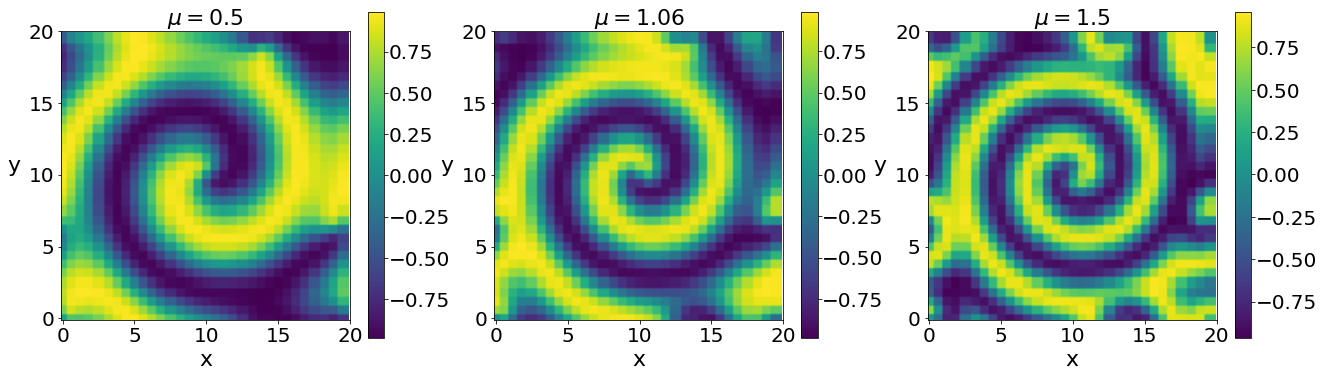

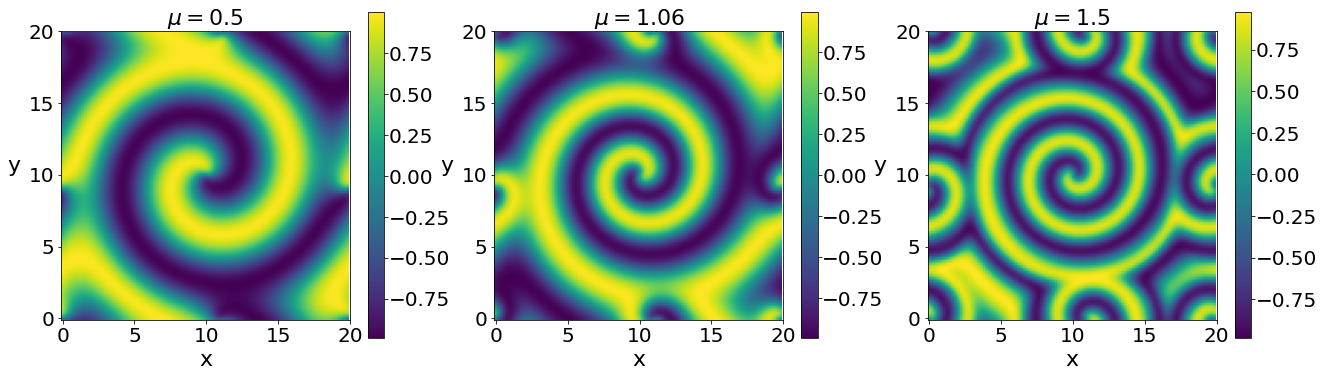

In [5]:
#########################   LF VS HF     ##########################
loc = np.arange(0,Nx_hf+1,int(Nx_hf/4))
tick = np.arange(0,21,5)

#Low-fidelity training data
fig = plt.figure(figsize=(22,6))
idx_mu_list = [0, int(N_mu_train/2), -1]
for i,idx_mu in enumerate(idx_mu_list):
    ax = fig.add_subplot(131 + i)
    surf = ax.imshow(u_lf[:,:,-1,idx_mu], origin = 'lower')
    plt.xticks(loc, tick,fontsize=20)
    plt.yticks(loc, tick,fontsize=20)
    plt.xlabel('x', rotation = 0,fontsize = 22)
    plt.ylabel('y', rotation = 0, fontsize = 22, labelpad=15)
    plt.title('$\mu = $' + str(round(mu_train[idx_mu],2)), fontsize = 22)
    cbar = plt.colorbar(surf)
    cbar.ax.tick_params(labelsize=20,pad=1)
    
#High-fidelity training data
fig = plt.figure(figsize=(22,6))
for i,idx_mu in enumerate(idx_mu_list):
    ax = fig.add_subplot(131 + i)
    surf = ax.imshow(u_hf[:,:,-1,idx_mu], origin = 'lower')
    plt.xticks(loc, tick,fontsize=20)
    plt.yticks(loc, tick,fontsize=20)
    plt.xlabel('x', rotation = 0,fontsize = 22)
    plt.ylabel('y', rotation = 0, fontsize = 22, labelpad=15)
    plt.title('$\mu = $' + str(round(mu_train[idx_mu],2)), fontsize = 22)
    cbar = plt.colorbar(surf)
    cbar.ax.tick_params(labelsize=20,pad=1)


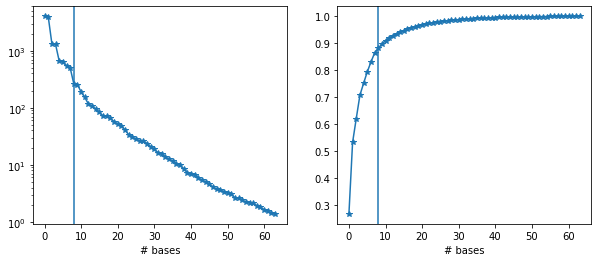

In [6]:
#########################   POD     ##########################
n_POD_large = 64 # we consider first a larger basis

#Reshape for POD
u_hf_pod = np.reshape(u_hf, (N, Nt_train*N_mu_train), 'F')

#POD on HF training data
POM_u, S_u = compute_randomized_SVD(u_hf_pod, n_POD_large, N, 1)

#We consider the first 9 POD modes
n_POD = 9

plt.figure(figsize = (10,4))
plt.subplot(121)
plt.plot(S_u,'*-')
plt.axvline(x = n_POD-1)
plt.yscale('log')
plt.xlabel('# bases')

plt.subplot(122)
plt.plot(np.cumsum(S_u)/np.sum(S_u),'*-')
plt.axvline(x = n_POD-1)
plt.xlabel('# bases')
plt.show()

POM_u = POM_u[:,:n_POD]
S_u = S_u[:n_POD]

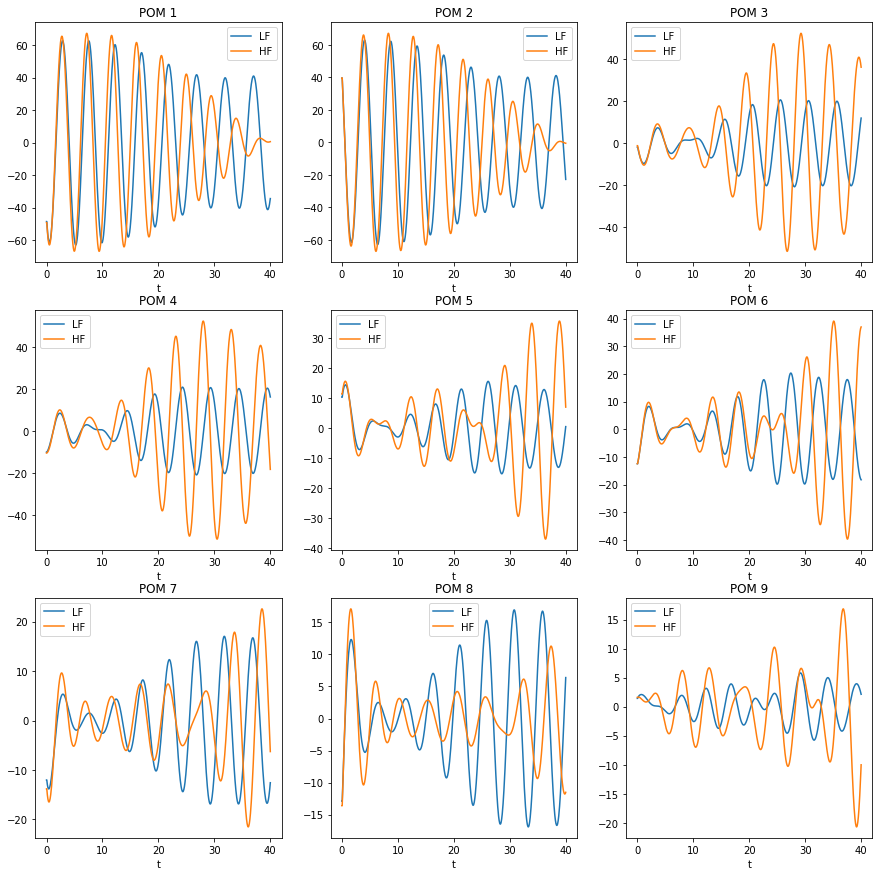

In [7]:
#########################   PROJECTION ONTO POD BASIS    ##########################
u_lf_pod = np.reshape(u_lf, (N, Nt_train*N_mu_train), 'F')
u_lf_test_pod = np.reshape(u_lf_test, (N, Nt_lf_test*N_mu_test), 'F')
u_hf_test_pod = np.reshape(u_hf_test, (N, Nt_test*N_mu_test), 'F')

ulf_train = u_lf_pod.T @ POM_u
uhf_train = u_hf_pod.T @ POM_u
ulf_test = u_lf_test_pod.T @ POM_u
uhf_test = u_hf_test_pod.T @ POM_u

#Reshape to make data suitable to LSTM network
ulf_train = np.reshape(ulf_train, (N_mu_train, Nt_train, -1))
uhf_train = np.reshape(uhf_train, (N_mu_train, Nt_train, -1))
ulf_test = np.reshape(ulf_test, (N_mu_test, Nt_lf_test, -1))
uhf_test = np.reshape(uhf_test, (N_mu_test, Nt_test, -1))

#Plot POD coefficients: LF vs HF
fig = plt.figure(figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(331 + i)
    plt.plot(t_lf, ulf_train[-1,:,i], label = 'LF')
    plt.plot(t_hf, uhf_train[-1, :, i], label = 'HF')
    ax.title.set_text('POM ' + str(i+1))
    plt.xlabel('t')
    plt.legend()
plt.show()

In [8]:
scaling = False
if scaling:
    scale = 1. / (1- S_u[:n_POD]/np.sum(S_u[:n_POD]))
    scale_param = 1/20.
else:
    scale =  1.
    scale_param = 1.

In [9]:
#Multi-fidelity network input: (time, param, LF data)
#train
t_train_lstm = np.tile(t_lf, N_mu_train).T.reshape(N_mu_train,-1,1)
mu_train_lstm = np.repeat(mu_train, Nt_train).reshape(N_mu_train,-1,1) / scale_param
ulf_train_lstm = ulf_train / scale

#test
t_test_lstm = np.tile(t_hf_test, N_mu_test).T.reshape(N_mu_test,-1,1)
mu_test_lstm = np.repeat(mu_test, Nt_test).reshape(N_mu_test,-1,1) / scale_param
ulf_test_lstm = ulf_test / scale

#concatenate in a single input
train_mf_lstm = np.concatenate((t_train_lstm, mu_train_lstm, ulf_train_lstm), axis=2)
test_mf_lstm = np.concatenate((t_test_lstm, mu_test_lstm, ulf_test_lstm), axis=2)

In [37]:
params_MF = {'batch': 17, 'lay': 2, 'lr':  0.009476420915650432,'lay_dense': 1, 'nodes_dense': 120, 'nodes': 120, 'opti': 'Adamax', 'sequence_freq': 7, 'sequence_length': 138,'epochs':  2000, 'patience' : 200, 'dropout' : 0.3}

In [38]:
train = True

In [ ]:

test5 = {'name' : 'diffusion/long40_80_coarse', 'Tlf' : 80., 'Thf' : 40., 'big' : True}
test6 = {'name' : 'diffusion/long40_80_coarse_NO_DIFF', 'Tlf' : 80., 'Thf' : 40., 'big' : True}
test7 = {'name' : 'diffusion_small', 'Tlf' : 80., 'Thf' : 40., 'big' : True}


test = test5#test7

folder =  test['name'] + '/'
path = './data/' + folder
if train:
    sequence_length = int(params_MF['sequence_length'])
    sequence_freq = int(params_MF['sequence_freq'])
    train_mf_lstm_seq, uhf_mf_train_seq = sliding_windows(train_mf_lstm, uhf_train, sequence_length, sequence_freq)

    model_MF = create_model(params_MF, train_mf_lstm.shape[2], uhf_train.shape[2])
    tf.random.set_seed(seed)
    hist_MF = train_model(params_MF, model_MF, train_mf_lstm_seq, uhf_mf_train_seq, verbose=1)

else:
    name = './models/model_train_new2'#'./models/model_MF_GOOD'#'./models/' + folder + 'model_MF_coarse' #model_MF_coarse_new #model_MF_12 #model_MF_good' #./models/model_MF_GOOD_scaled
    #name = './models/'+ folder + 'model_MF_coarse_5%'
    #easier model_MF_12_new  params_MF = {'batch': 17, 'lay': 2, 'lr':  0.0009476420915650432,'lay_dense': 1, 'nodes_dense': 120, 'nodes': 120, 'opti': 'Adamax', 'sequence_freq': 7, 'sequence_length': 138,'epochs':  NepoLF, 'patience' : 100, 'dropout' : 0.3}
    # {'batch': 17, 'lay': 2, 'lr': 0.02167199871091151,'lay_dense': 1, 'nodes_dense': 120, 'nodes': 120, 'opti': 'Adamax', 'sequence_freq': 7, 'sequence_length': 138,'epochs':  NepoLF, 'patience' : 50, 'dropout' : 0.3}

    #diffusion model_MF_12_scaled params_MF = {'batch': 17, 'lay': 2, 'lr':  0.0009476420915650432,'lay_dense': 1, 'nodes_dense': 120, 'nodes': 120, 'opti': 'Adamax', 'sequence_freq': 10, 'sequence_length': 160,'epochs':  NepoLF, 'patience' : 150, 'dropout' : 0.3}
    if scaling:
        name = name + '_scaled'
    model_MF = load_model(name)
if save:
    name = './models/model_train_new2' #'model_train_new' #'./models/model_train_new1'
    if scaling:
        name = name + '_scaled'
    save_model(model_MF, name)

Epoch 1/2000
56/56 [==============================] - 7s 83ms/step - loss: 96.8662 - mse: 96.8662
Epoch 2/2000
56/56 [==============================] - 5s 85ms/step - loss: 17.8383 - mse: 17.8383
Epoch 3/2000
56/56 [==============================] - 5s 85ms/step - loss: 10.3579 - mse: 10.3579
Epoch 4/2000
56/56 [==============================] - 5s 88ms/step - loss: 6.2657 - mse: 6.2657
Epoch 5/2000
56/56 [==============================] - 5s 88ms/step - loss: 4.3433 - mse: 4.3433
Epoch 6/2000
56/56 [==============================] - 5s 88ms/step - loss: 3.3311 - mse: 3.3311
Epoch 7/2000
56/56 [==============================] - 5s 89ms/step - loss: 2.9196 - mse: 2.9196
Epoch 8/2000
56/56 [==============================] - 5s 94ms/step - loss: 2.6596 - mse: 2.6596
Epoch 9/2000
56/56 [==============================] - 5s 88ms/step - loss: 2.3553 - mse: 2.3553
Epoch 10/2000
56/56 [==============================] - 5s 89ms/step - loss: 2.1869 - mse: 2.1869
Epoch 11/2000
56/56 [============

Epoch 85/2000
56/56 [==============================] - 5s 97ms/step - loss: 0.3559 - mse: 0.3559
Epoch 86/2000
56/56 [==============================] - 5s 97ms/step - loss: 0.5220 - mse: 0.5220
Epoch 87/2000
56/56 [==============================] - 5s 97ms/step - loss: 0.4556 - mse: 0.4556
Epoch 88/2000
56/56 [==============================] - 5s 98ms/step - loss: 0.5124 - mse: 0.5124
Epoch 89/2000
56/56 [==============================] - 5s 97ms/step - loss: 0.4273 - mse: 0.4273
Epoch 90/2000
56/56 [==============================] - 5s 98ms/step - loss: 0.4826 - mse: 0.4826
Epoch 91/2000
56/56 [==============================] - 6s 99ms/step - loss: 0.4452 - mse: 0.4452
Epoch 92/2000
56/56 [==============================] - 6s 106ms/step - loss: 0.4845 - mse: 0.4845
Epoch 93/2000
56/56 [==============================] - 7s 131ms/step - loss: 0.4954 - mse: 0.4954
Epoch 94/2000
56/56 [==============================] - 6s 112ms/step - loss: 0.4034 - mse: 0.4034
Epoch 95/2000
56/56 [======

In [26]:
uMF_LSTM_train = model_MF.predict(train_mf_lstm).reshape(N_mu_train, Nt_train, -1) * scale
uMF_LSTM_test = model_MF.predict(test_mf_lstm).reshape(N_mu_test, Nt_test, -1) * scale

1/1 [==============================] - 1s 790ms/step


In [27]:
uMF_LSTM_train_rec = (uMF_LSTM_train @ POM_u.T).reshape(N_mu_train, Nt_train, Nx_hf, Ny_hf)
uhf_train_rec = (uhf_train @ POM_u.T).reshape(N_mu_train, Nt_train, Nx_hf, Ny_hf)
uMF_LSTM_test_rec = (uMF_LSTM_test @ POM_u.T).reshape(N_mu_test, Nt_test, Nx_hf, Ny_hf)
uhf_test_rec = (uhf_test @ POM_u.T).reshape(N_mu_test, Nt_test, Nx_hf, Ny_hf)

In [30]:
from celluloid import Camera
from matplotlib.animation import PillowWriter
from IPython.display import HTML

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

camera = Camera(fig)
mu = 9
for i in range(0, 1600, 5):
    surf = ax[0].imshow(u_lf_test[:, :, i, mu], vmin=-1, vmax=1)
    surf = ax[1].imshow(uMF_LSTM_test_rec[mu, i, :, :].T, vmin=-1, vmax=1)
    surf = ax[2].imshow(u_hf_test[:, :, i, mu], vmin=-1, vmax=1)
    surf = ax[3].imshow(
        np.abs(uMF_LSTM_test_rec[mu, i, :, :] - uhf_test_rec[mu, i, :, :]),
        cmap='bwr',
        vmin=1e-5,
        vmax=np.max(np.abs(uMF_LSTM_test_rec[mu, :, :, :] - uhf_test_rec[mu, :, :, :])),
    )
    camera.snap()
fig.suptitle("$\mu$ = " + str(round(mu_test[mu],3)), fontsize = 22)
animation = camera.animate()


# Close the figure to prevent it from being displayed
plt.close(fig)

# Save the animation as a GIF using PillowWriter
name = "test_HF_" + str(round(mu_test[mu],3)) + "_.gif"
animation.save(name, writer=PillowWriter(fps=10))

# Add a title to the figure


# Display the saved GIF
HTML("<img src='" + name + "'>")

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

camera = Camera(fig)
mu = -2
for i in range(0, 1600, 5):
    surf = ax[0].imshow(u_lf_test[:, :, i, mu], vmin=-1, vmax=1)
    surf = ax[1].imshow(uMF_LSTM_test_rec[mu, i, :, :].T, vmin=-1, vmax=1)
    surf = ax[2].imshow(u_hf_test[:, :, i, mu], vmin=-1, vmax=1)
    surf = ax[3].imshow(
        np.abs(uMF_LSTM_test_rec[mu, i, :, :] - uhf_test_rec[mu, i, :, :]),
        cmap='bwr',
        vmin=1e-5,
        vmax=np.max(np.abs(uMF_LSTM_test_rec[mu, :, :, :] - uhf_test_rec[mu, :, :, :])),
    )
    camera.snap()
fig.suptitle("$\mu$ = " + str(round(mu_test[mu],3)), fontsize = 22)
animation = camera.animate()


# Close the figure to prevent it from being displayed
plt.close(fig)

# Save the animation as a GIF using PillowWriter
name = "test_HF_" + str(round(mu_test[mu],3)) + "_.gif"
animation.save(name, writer=PillowWriter(fps=10))

# Add a title to the figure


# Display the saved GIF
HTML("<img src='" + name + "'>")

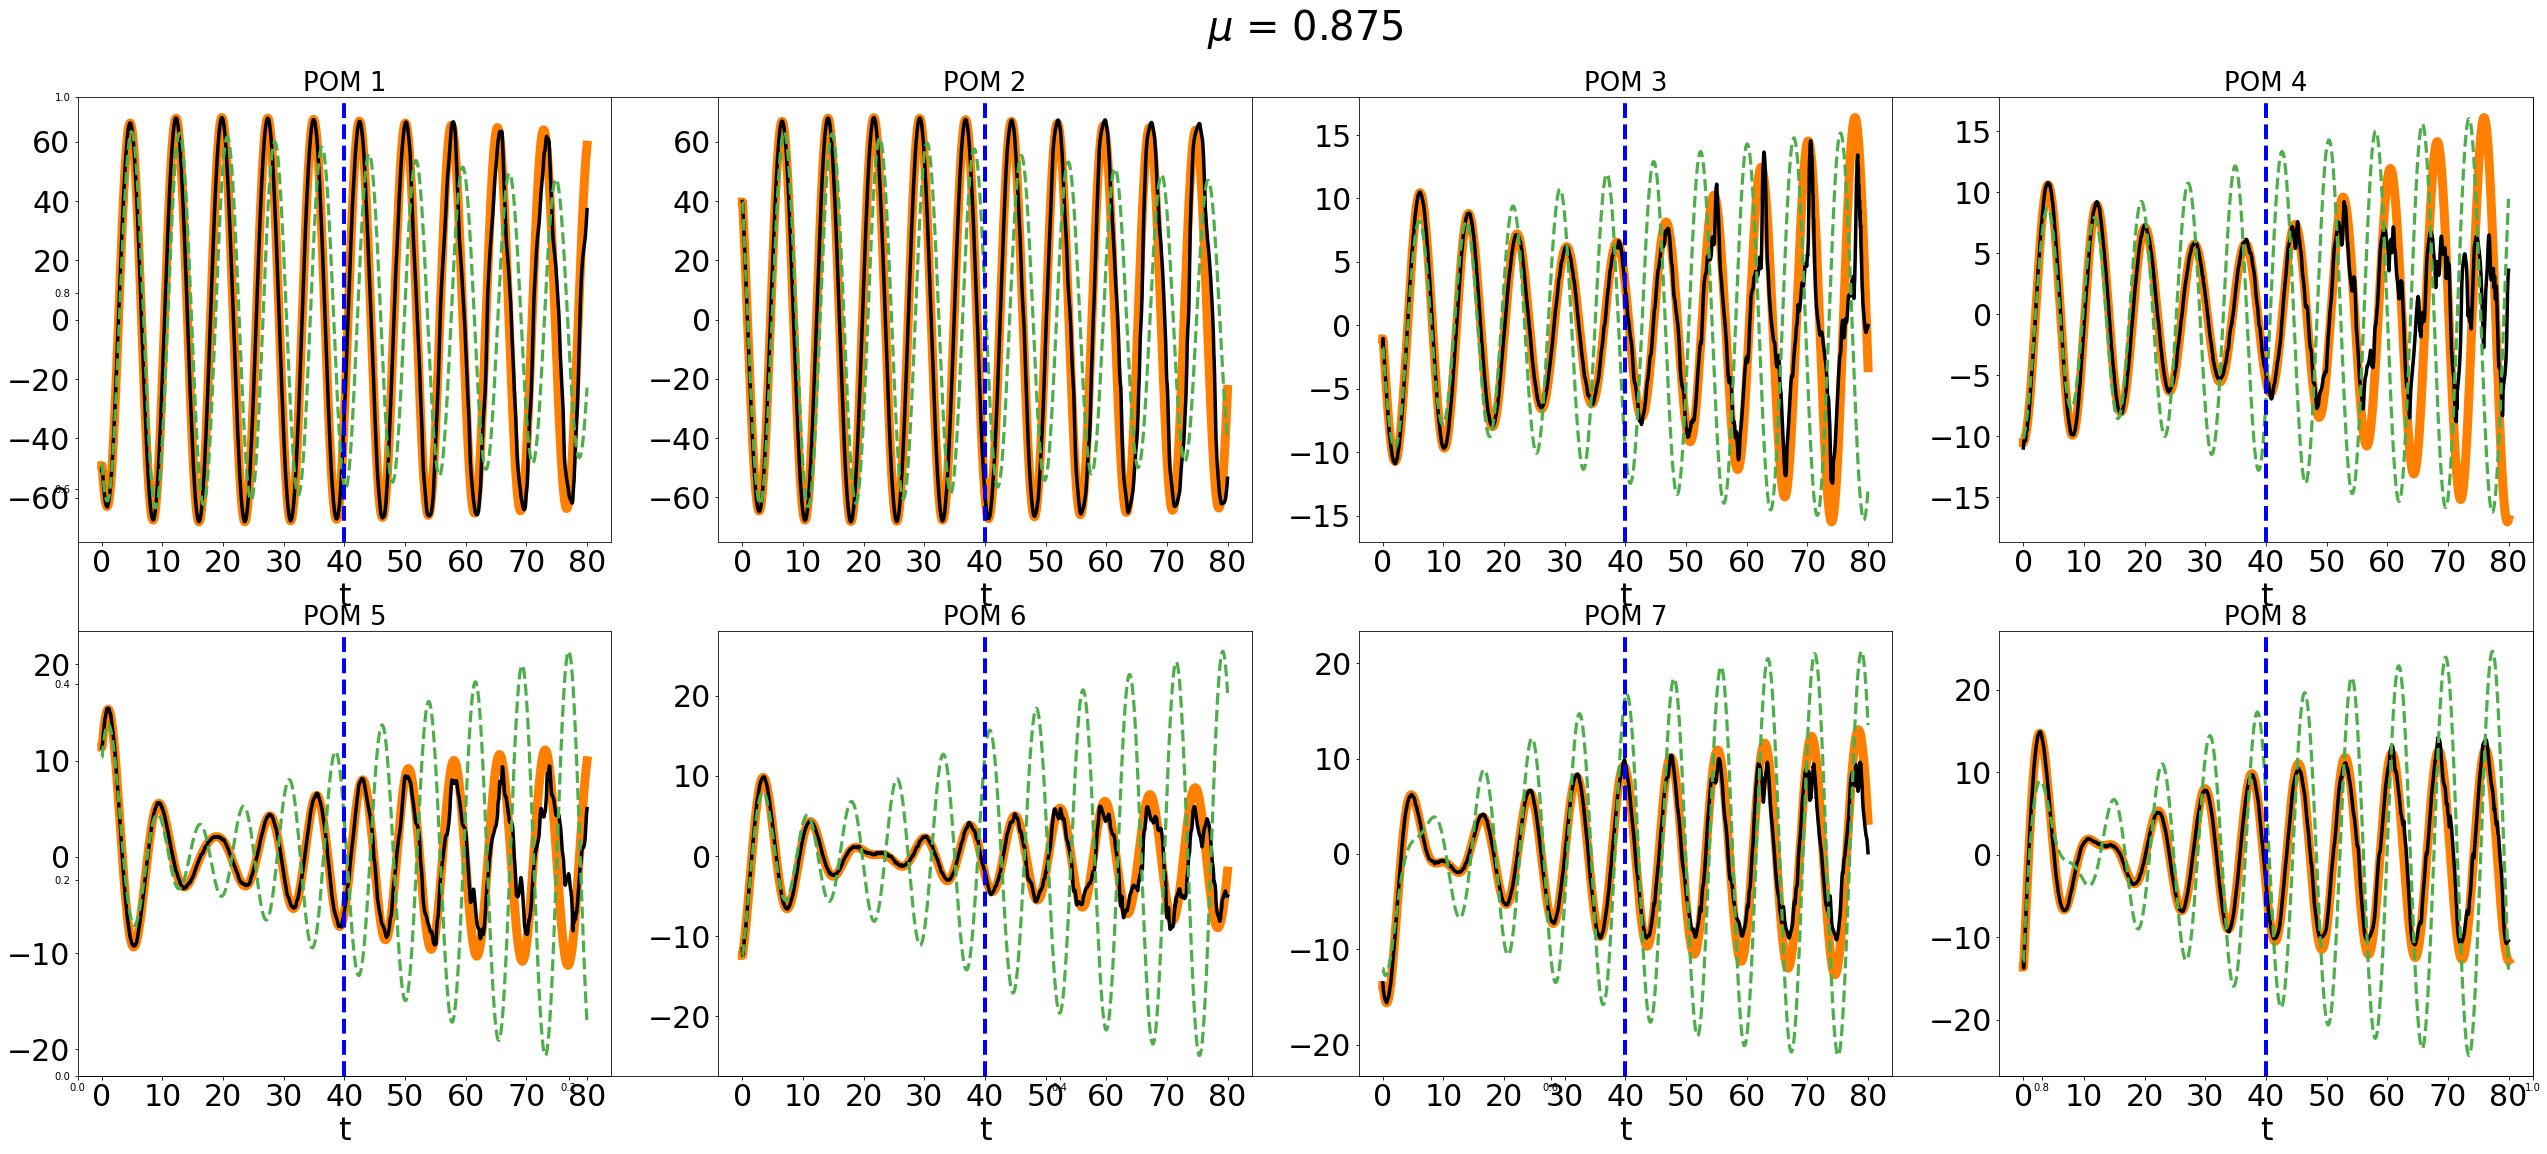

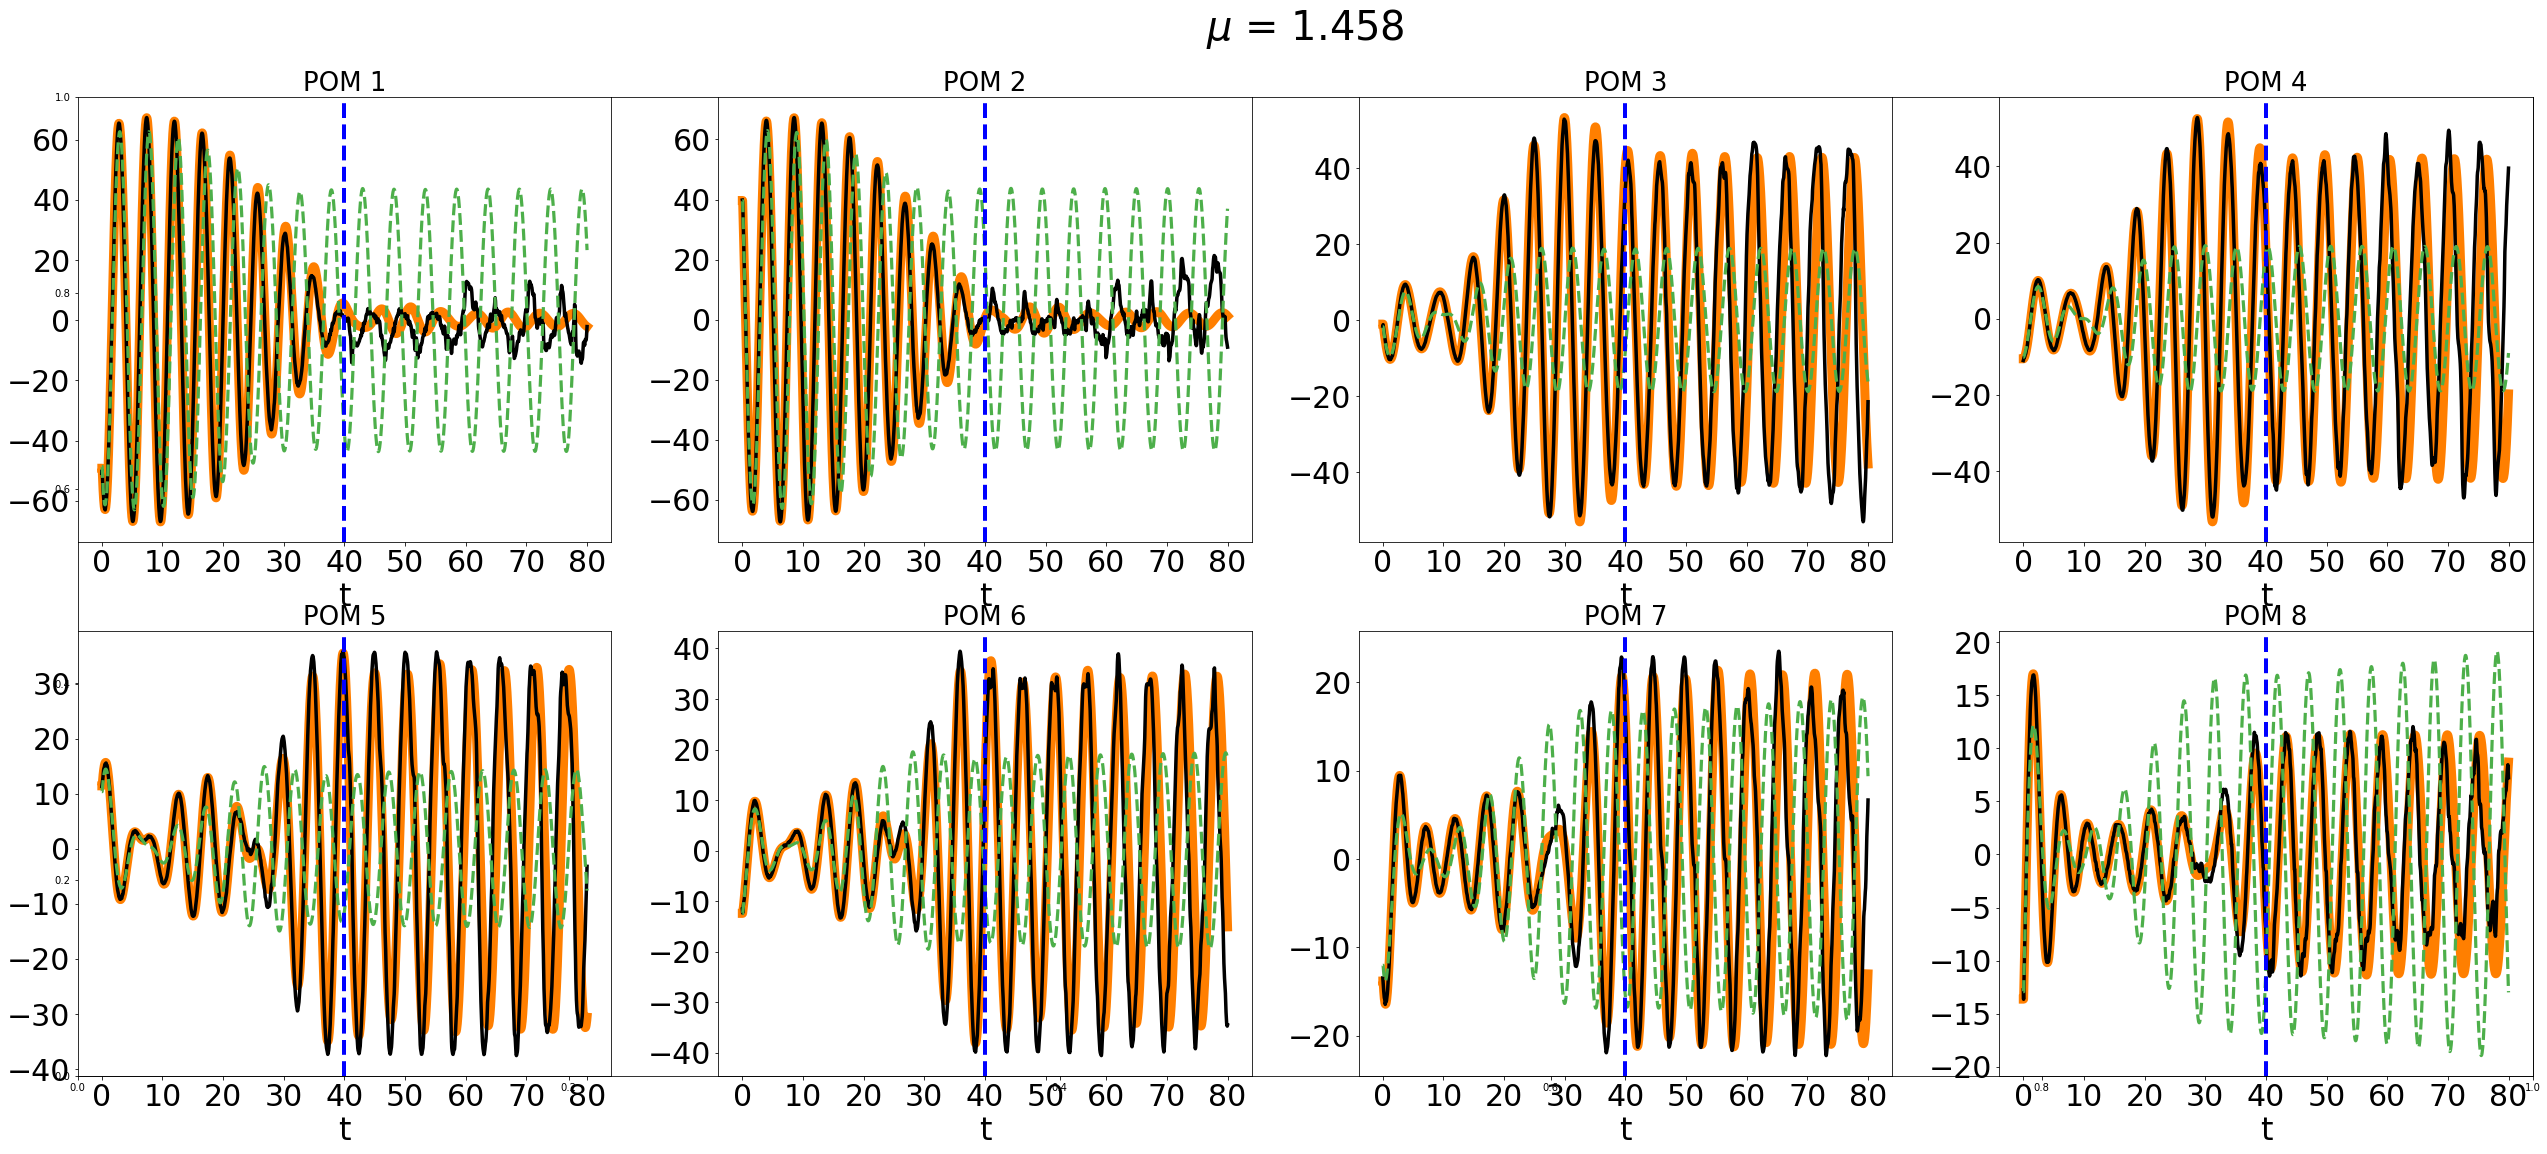

In [33]:
for j in [9,-2]: #  range(len(mu_test)):
    fig = plt.figure(figsize=(44,18)) #38,18
    plt.title('$\mu$ = ' + str(mu_test[j].round(3)) + '\n', fontsize = 40)
    for i in range(8):
        ax = fig.add_subplot(241 + i)

        plt.plot(t_hf_test, uhf_test[j, :, i],'-', color = '#ff7f00', label = 'real', linewidth = 9)#6.8)
        plt.plot(t_hf_test, uMF_LSTM_test[j, :, i],'k-', label = 'pred', linewidth = 3.5)# color = '#377eb8',
        plt.plot(t_hf_test, ulf_test[j, :, i], '--', color='#4daf4a', linewidth=3.2)

        #plt.plot(t_hf, uhf_train[j, :, i])


        #plt.plot(t_hf, uMF_LSTM_train[j,:,i])
        plt.axvline(x=Thf, linestyle='--', color='blue', linewidth = 4)
        ax.set_title('POM ' + str(i + 1), fontsize = 26)
        #ax.title.set_text('POM ' + str(i + 1))
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.xlabel('t', rotation=0, fontsize=32)
        #plt.ylabel('y', rotation=0, fontsize=22, labelpad=15)
        #plt.legend(loc = 'upper left')
    plt.show()